<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

#  Capstone Project: Train Delays Predictor
---

### Problem Statement and Solution Approach:

**Problem:**<br>
Despite ongoing efforts to improve the MRT system, train delays and faults persist, causing frustration and inconvenience for passengers.

**Proposed Solution:**<br>As a daily commuter of Singapore MRT, I aim to develop a train delays predictor that can identify stations and timings that are more likely to experience breakdowns or delays. 

By analyzing historical data on time of day, type of day, station name, commuter volume, and breakdown/non-breakdown indicators, I hope to create a model that can accurately predict future breakdowns and help commuters avoid stations and times with potential delays.

### Data used:
Data used in the analysis consists of SMRT information from the Land Transport Authorithy and SMRT tweets about train faults scrapped from SMRT Twitter profile page. Please rerefer to the data dictionary for more information on the columns extracted.

### Data Collection
Refer to **1. Data Collection** notebook.

## Data Cleaning: trainFault (From Twitter)

### Context:
To clean the scraped data and get relevant information (faults/delay) out of it. 

In [55]:
#Import Dependencies

import pandas as pd
from datetime import datetime
from pytz import timezone
import re
import datetime
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**Load csv file scraped from Twitter**

In [17]:
# Assign filepath
alltweets = "datasets/tweets_2018_to_2023.csv"

# Load the data into a pandas DataFrame
trainFault_df1 = pd.read_csv(alltweets, encoding='ISO-8859-1')
df.head()

,train_line,day_type,year_month,time_per_hour,Timestamp,station_name,pt_code,fault_type,Tweet
0,NSL,WEEKDAY,2023-02,10,2023-02-22 10:45:37+08:00,WOODLANDS,NS9/TE2,train,"['[NSL] Update : Due to a train fault, pls add..."
1,NSL,WEEKDAY,2023-02,10,2023-02-22 10:42:33+08:00,ADMIRALTY,NS10,train,"['[NSL] Update : Due to a train fault, pls add..."
2,NSL,WEEKDAY,2023-02,10,2023-02-22 10:25:58+08:00,SEMBAWANG,NS11,train,"['[NSL]: Due to a train fault, pls add 25mins ..."
3,NSL,WEEKDAY,2023-02,10,2023-02-22 10:21:02+08:00,CANBERRA,NS12,train,"['[NSL]: Due to a train fault, pls add 15mins ..."
4,NSL,WEEKDAY,2023-02,10,2023-02-22 10:10:23+08:00,YISHUN,NS13,train,"['[NSL]: Due to a train fault, pls add 15mins ..."


**a. Initial examination of its data.**

In [18]:
# How many rows and columns are there in the data scraped?

print(f'there are {trainFault_df1.shape[0]} rows and {trainFault_df1.shape[1]} columns')

there are 705 rows and 2 columns


In [19]:
# Check the type of data in each column, check whether there is null in the data

trainFault_df1.info()
pd.DataFrame(trainFault_df1.dtypes, columns=["DataTypes"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  705 non-null    object
 1   Tweet      705 non-null    object
dtypes: object(2)
memory usage: 11.1+ KB


,DataTypes
Timestamp,object
Tweet,object


**b. Cleaning time column and converting it from ZULU timezone to SG timezone**

In [20]:
# Convert timestamp column to datetime objects and convert timezone to SGT
trainFault_df1['Timestamp'] = pd.to_datetime(trainFault_df1['Timestamp']).apply(lambda x: x.astimezone(timezone('Asia/Singapore')))

# display the cleaned dataframe
trainFault_df1

,Timestamp,Tweet
0,2023-02-22 11:14:34+08:00,['[Update]: Train services between #Woodlands ...
1,2023-02-22 11:10:28+08:00,['[NSL] UPDATE: Train svcs between Woodlands a...
2,2023-02-22 10:56:03+08:00,"['[NSL] UPDATE: Fault cleared, train svcs betw..."
3,2023-02-22 10:45:37+08:00,"['[NSL] Update : Due to a train fault, pls add..."
4,2023-02-22 10:42:33+08:00,"['[NSL] Update : Due to a train fault, pls add..."
...,...,...
700,2018-01-02 06:13:41+08:00,['[EWL] UPDATE: Svc expected to resume at 06:2...
701,2018-01-02 05:59:07+08:00,['[EWL] UPDATE: Free regular bus & free bridgi...
702,2018-01-02 05:56:34+08:00,"['For details on bus services, our bus guides ..."
703,2018-01-02 05:49:14+08:00,"['[EWL]: Due to a track signalling fault, pls ..."


**c. Create two new columns being (i) day_type and (ii) time_per_hour**

In [22]:
# convert Timestamp column to datetime data type
trainFault_df1['Timestamp'] = pd.to_datetime(trainFault_df1['Timestamp'])

# extract hour from datetime column
trainFault_df1['time_per_hour'] = trainFault_df1['Timestamp'].dt.hour

# create day_type column based on day_of_week
trainFault_df1['day_type'] = trainFault_df1['Timestamp'].apply(lambda x: 'WEEKDAY' if x.weekday() < 5 else 'WEEKENDS/HOLIDAY')

# create year_month column
trainFault_df1['year_month'] = trainFault_df1['Timestamp'].dt.strftime('%Y-%m')

# display the cleaned dataframe
trainFault_df1

,Timestamp,Tweet,time_per_hour,day_type,year_month
0,2023-02-22 11:14:34+08:00,['[Update]: Train services between #Woodlands ...,11,WEEKDAY,2023-02
1,2023-02-22 11:10:28+08:00,['[NSL] UPDATE: Train svcs between Woodlands a...,11,WEEKDAY,2023-02
2,2023-02-22 10:56:03+08:00,"['[NSL] UPDATE: Fault cleared, train svcs betw...",10,WEEKDAY,2023-02
3,2023-02-22 10:45:37+08:00,"['[NSL] Update : Due to a train fault, pls add...",10,WEEKDAY,2023-02
4,2023-02-22 10:42:33+08:00,"['[NSL] Update : Due to a train fault, pls add...",10,WEEKDAY,2023-02
...,...,...,...,...,...
700,2018-01-02 06:13:41+08:00,['[EWL] UPDATE: Svc expected to resume at 06:2...,6,WEEKDAY,2018-01
701,2018-01-02 05:59:07+08:00,['[EWL] UPDATE: Free regular bus & free bridgi...,5,WEEKDAY,2018-01
702,2018-01-02 05:56:34+08:00,"['For details on bus services, our bus guides ...",5,WEEKDAY,2018-01
703,2018-01-02 05:49:14+08:00,"['[EWL]: Due to a track signalling fault, pls ...",5,WEEKDAY,2018-01


**d. Cleaning Tweet column**

In [23]:
# define the extract_train_line functions
def extract_train_line(tweet):
    match = re.search(r'\[([A-Z]+)\]', tweet)
    if match:
        return match.group(1)
    else:
        return None

# Apply extract_train_line() function to each row in "Tweet" column
trainFault_df1['train_line'] = trainFault_df1['Tweet'].apply(extract_train_line)

In [24]:
# filtered for tweets that contain 'fault'
trainFault_df1 = trainFault_df1[trainFault_df1['Tweet'].apply(str.lower).str.contains('fault|track')]

# remove tweets that contain 'cleared'
trainFault_df1 = trainFault_df1[~trainFault_df1['Tweet'].apply(str.lower).str.contains('cleared')]


In [25]:
# Export to csv

trainFault_df1.to_csv('dataset_1.1.csv', index=False)

#### From here, I have to export the data to manually add in all the affected stations from excel.

1. For example, if the tweet says from **"fault from station_A to station_D"**, I will create each row for station A, station B, station C and station D per **time_per_hour** and **per year_month**.

2. I have also added the **fault type** manually based on the tweets

After manually adding the above, I loaded the updated csv file below again.

In [26]:
# Assign filepath
cleantweets = "datasets/faults_delay_affected_stations.csv"

# Load the data into a pandas DataFrame
trainFault_df2 = pd.read_csv(cleantweets, encoding='ISO-8859-1')
trainFault_df2.head()

,train_line,day_type,year_month,time_per_hour,Timestamp,station_name,pt_code,fault_type,Tweet
0,NSL,WEEKDAY,2023-02,10,2023-02-22 10:45:37+08:00,WOODLANDS,NS9/TE2,train,"['[NSL] Update : Due to a train fault, pls add..."
1,NSL,WEEKDAY,2023-02,10,2023-02-22 10:42:33+08:00,ADMIRALTY,NS10,train,"['[NSL] Update : Due to a train fault, pls add..."
2,NSL,WEEKDAY,2023-02,10,2023-02-22 10:25:58+08:00,SEMBAWANG,NS11,train,"['[NSL]: Due to a train fault, pls add 25mins ..."
3,NSL,WEEKDAY,2023-02,10,2023-02-22 10:21:02+08:00,CANBERRA,NS12,train,"['[NSL]: Due to a train fault, pls add 15mins ..."
4,NSL,WEEKDAY,2023-02,10,2023-02-22 10:10:23+08:00,YISHUN,NS13,train,"['[NSL]: Due to a train fault, pls add 15mins ..."


**e. Re-order and keep only relevant columns**

In [27]:
# Check for null values after cleaning tweets using functions

trainFault_df2.isnull().sum().sort_values(ascending=False)

Timestamp        690
Tweet            690
train_line         0
day_type           0
year_month         0
time_per_hour      0
station_name       0
pt_code            0
fault_type         0
dtype: int64

In [28]:
# Drop unnecessary columns and re-order the remaining columns

trainFault_df = trainFault_df2.drop(['Timestamp', 'Tweet'], axis=1)[['year_month', 'day_type', 'time_per_hour', 'pt_code','station_name','train_line','fault_type']]

In [86]:
trainFault_df.shape

(922, 7)

In [29]:
# Display new_df

trainFault_df.sample(5)

,year_month,day_type,time_per_hour,pt_code,station_name,train_line,fault_type
121,2022-11,WEEKDAY,5,BP10,FAJAR,BPLRT,power
423,2020-12,WEEKDAY,7,TE3,WOODLANDS SOUTH,TEL,signal
723,2018-12,WEEKDAY,5,EW28,PIONEER,EWL,track
800,2018-09,WEEKDAY,9,EW24/NS1,JURONG EAST,EWL,door
918,2018-01,WEEKDAY,16,BP4,TECK WHYE,BPLRT,train


**Export data**

In [30]:
# Export to csv

trainFault_df.to_csv('dataset_1.2.csv', index=False)

## Data cleaning: passenger dataset (From LTA) 

### Context:
1. Data source downloaded from LTA using API only consists of 3 months latest tap-in and tap-out data (December 2022, January 2023 and February 2023)
2. To impute the missing data from January 2018 to November 2022 using sk learn to match the period of the scraped data from Twitter

**a. Load csv and do an initial examination of its data**

In [32]:
# Assign filepath
passenger_final = "datasets/passengers_201801_202302__before impute.csv"

# Load the data into a pandas DataFrame
passenger_df1 = pd.read_csv(passenger_final, encoding='ISO-8859-1')


In [33]:
# How many rows and columns are there in the downloaded LTA datasets from period Dec-22 to Feb-23?

print(f'there are {passenger_df1.shape[0]} rows and {passenger_df1.shape[1]} columns')

there are 424022 rows and 7 columns


In [34]:
# Check the type of data in each column, check whether there is null in the data

passenger_df1.info()
pd.DataFrame(passenger_df1.dtypes, columns=["DataTypes"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424022 entries, 0 to 424021
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year_month            424022 non-null  object 
 1   day_type              424022 non-null  object 
 2   time_per_hour         424022 non-null  int64  
 3   pt_code               424022 non-null  object 
 4   station_name          424022 non-null  object 
 5   total_tap_in_volume   20462 non-null   float64
 6   total_tap_out_volume  20462 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 22.6+ MB


,DataTypes
year_month,object
day_type,object
time_per_hour,int64
pt_code,object
station_name,object
total_tap_in_volume,float64
total_tap_out_volume,float64


**b. Imputing data from Jan-2018 to Nov-2022 using scikit learn**

In [35]:
# Checking how many rows of missing data that needs to be imputed

print(passenger_df1.isna().sum())

year_month                   0
day_type                     0
time_per_hour                0
pt_code                      0
station_name                 0
total_tap_in_volume     403560
total_tap_out_volume    403560
dtype: int64


In [36]:
# Create label encoders for non-numerical columns

label_encoders = {}
for col in ['year_month', 'day_type', 'time_per_hour', 'pt_code', 'station_name']:
    label_encoders[col] = LabelEncoder()
    passenger_df1[col] = label_encoders[col].fit_transform(passenger_df1[col])

In [44]:
# Create an instance of iterative imputer
imputer = IterativeImputer(random_state=42)

# Fit the imputer on the dataset
imputer.fit(passenger_df1)

# Transform the dataset
passenger_df = imputer.transform(passenger_df1)

# Convert the imputed dataset back to a pandas dataframe
passenger_df = pd.DataFrame(passenger_df, columns=passenger_df1.columns)

# Inverse transform the encoded columns
for col in ['year_month', 'day_type', 'time_per_hour', 'pt_code', 'station_name']:
    passenger_df[col] = label_encoders[col].inverse_transform(passenger_df[col].astype(int))


In [45]:
# Check again for missing values to confirm that they have been imputed

print(passenger_df.isna().sum())

year_month              0
day_type                0
time_per_hour           0
pt_code                 0
station_name            0
total_tap_in_volume     0
total_tap_out_volume    0
dtype: int64


In [46]:
# Displaying imputed dataframe

passenger_df.sample(5)

,year_month,day_type,time_per_hour,pt_code,station_name,total_tap_in_volume,total_tap_out_volume
377299,2018-07,WEEKDAY,6,CC8,DAKOTA,12551.628884,14808.241280
97460,2021-12,WEEKDAY,5,CC10/DT26,MACPHERSON,7378.871565,7849.890423
7053,2023-01,WEEKENDS/HOLIDAY,15,EW23,CLEMENTI,17453.000000,17396.000000
12713,2023-01,WEEKENDS/HOLIDAY,13,EW22,DOVER,2644.000000,2831.000000
66350,2022-05,WEEKENDS/HOLIDAY,15,CC19/DT9,BOTANIC GARDENS,6593.810236,6442.870773


**Export data**

In [43]:
# Export to csv

passenger_df.to_csv('dataset_2.csv', index=False)

## Data Cleaning: Combining Dataset 1 (from Twitter) and Dataset 2 (from LTA)


### Context:
1. Combining both trainFault_df and passenger_df
2. Create new relevant columns to prepare for modeling 

**Load both datasets csv** 

In [47]:
# Assign filepath
delay_fault = "dataset_1.2.csv"
passenger = "dataset_2.csv"

# Load the data into a pandas DataFrame
trainFault_df = pd.read_csv(delay_fault, encoding='ISO-8859-1')
passenger_df = pd.read_csv(passenger, encoding='ISO-8859-1')

**a. Remove duplicates in dataset 1.2**

Apparently, as below, I have made some human error when imputing the affected stations manually, thus, removing duplicates help to recitify this.

In [48]:
# identify the columns to check for duplicates
duplicate_columns = ['year_month', 'day_type', 'time_per_hour', 'pt_code', 'station_name',
       'train_line', 'fault_type']

# create a Boolean mask to identify which rows are duplicates
mask = trainFault_df.duplicated(subset=duplicate_columns, keep=False)

# filter the DataFrame to keep only the duplicate rows
duplicate_rows = trainFault_df[mask]

# display
duplicate_rows

,year_month,day_type,time_per_hour,pt_code,station_name,train_line,fault_type
13,2023-02,WEEKDAY,7,NS9/TE2,WOODLANDS,NSL,track
14,2023-02,WEEKDAY,7,NS10,ADMIRALTY,NSL,track
15,2023-02,WEEKDAY,7,NS11,SEMBAWANG,NSL,track
16,2023-02,WEEKDAY,7,NS12,CANBERRA,NSL,track
17,2023-02,WEEKDAY,7,NS13,YISHUN,NSL,track
18,2023-02,WEEKDAY,6,NS9/TE2,WOODLANDS,NSL,track
19,2023-02,WEEKDAY,6,NS10,ADMIRALTY,NSL,track
20,2023-02,WEEKDAY,6,NS11,SEMBAWANG,NSL,track
21,2023-02,WEEKDAY,6,NS12,CANBERRA,NSL,track
22,2023-02,WEEKDAY,6,NS13,YISHUN,NSL,track


In [49]:
# Drop duplicates

trainFault_df = trainFault_df.drop_duplicates(subset=None, keep="first", inplace=False)

# New trainFault_df shape

trainFault_df.shape

(922, 7)

**b. Combining trainFault_df and passenger_df using outer join and create a new column 'fault' which will be our target variable to predict**

In [69]:
# merge the dataframes on the common columns
combinedSmrt_df1 = pd.merge(trainFault_df, passenger_df, on=['year_month', 'day_type', 'time_per_hour', 'pt_code', 'station_name'], how='outer')

# create the 'fault' column based on the presence of matching records
combinedSmrt_df1['fault'] = combinedSmrt_df1['fault_type'].apply(lambda x:1 if pd.notna(x) else 0)

In [70]:
# reorder the columns as desired

combinedSmrt_df = combinedSmrt_df1[['year_month', 'day_type', 'time_per_hour', 'pt_code', 'station_name', 'total_tap_in_volume', 'total_tap_out_volume', 'fault', 'fault_type']]

**Export data**

In [63]:
# Export to csv

combinedSmrt_df.to_csv('almost_final_df.csv', index=False)

## Data Analysis: Exploratory data analysis & Feature Engineering


### Context:
1. Just some basic EDA (most of the EDA will be done in Tableau)

### Understanding dataset

**a. Initial examination of data**

In [71]:
# How many rows and columns are there in the data scraped?

print(f'there are {combinedSmrt_df.shape[0]} rows and {combinedSmrt_df.shape[1]} columns')

there are 424033 rows and 9 columns


In [72]:
# Check the type of data in each column, check whether there is null in the data

combinedSmrt_df.info()
pd.DataFrame(combinedSmrt_df.dtypes, columns=["DataTypes"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424033 entries, 0 to 424032
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year_month            424033 non-null  object 
 1   day_type              424033 non-null  object 
 2   time_per_hour         424033 non-null  int64  
 3   pt_code               424033 non-null  object 
 4   station_name          424033 non-null  object 
 5   total_tap_in_volume   424032 non-null  float64
 6   total_tap_out_volume  424032 non-null  float64
 7   fault                 424033 non-null  int64  
 8   fault_type            922 non-null     object 
dtypes: float64(2), int64(2), object(5)
memory usage: 32.4+ MB


,DataTypes
year_month,object
day_type,object
time_per_hour,int64
pt_code,object
station_name,object
total_tap_in_volume,float64
total_tap_out_volume,float64
fault,int64
fault_type,object


In [73]:
# Descriptive Statistics

combinedSmrt_df.describe()

,time_per_hour,total_tap_in_volume,total_tap_out_volume,fault
count,424033.000000,424032.000000,424032.000000,424033.000000
mean,13.301717,9964.505841,11188.301667,0.002174
std,6.147511,3408.525360,4134.387081,0.046579
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,8173.740523,8713.201259,0.000000
50%,14.000000,10025.987376,11265.022593,0.000000
75%,19.000000,11827.253473,13741.098411,0.000000
max,23.000000,140538.000000,133244.000000,1.000000


**b. Creating a new column to measure the traffic level**

In [74]:
# Create new column being total tap in plus total tap out to measure traffic level
combinedSmrt_df = combinedSmrt_df.assign (traffic_volume = lambda df :round(combinedSmrt_df['total_tap_in_volume'] + combinedSmrt_df['total_tap_out_volume'],2))
combinedSmrt_df['traffic_volume'] = combinedSmrt_df['traffic_volume'].apply(lambda x: max(0, x))

# Display sample
combinedSmrt_df.sample(5)

,year_month,day_type,time_per_hour,pt_code,station_name,total_tap_in_volume,total_tap_out_volume,fault,fault_type,traffic_volume
117238,2021-09,WEEKENDS/HOLIDAY,20,DT10/TE11,STEVENS,6957.474832,7444.373660,0,NaN,14401.85
316620,2019-04,WEEKENDS/HOLIDAY,9,CC10/DT26,MACPHERSON,8752.466844,9785.119633,0,NaN,18537.59
185790,2020-11,WEEKDAY,22,CC5,NICOLL HIGHWAY,11111.029823,13123.558113,0,NaN,24234.59
370076,2018-08,WEEKDAY,10,SW4,THANGGAM,13258.066636,15822.639399,0,NaN,29080.71
139627,2021-06,WEEKENDS/HOLIDAY,11,NS13,YISHUN,6642.056147,6804.655354,0,NaN,13446.71


**c. Correlation matrix for all columns**

C:\Users\qiyua\AppData\Local\Temp\ipykernel_9224\830022195.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


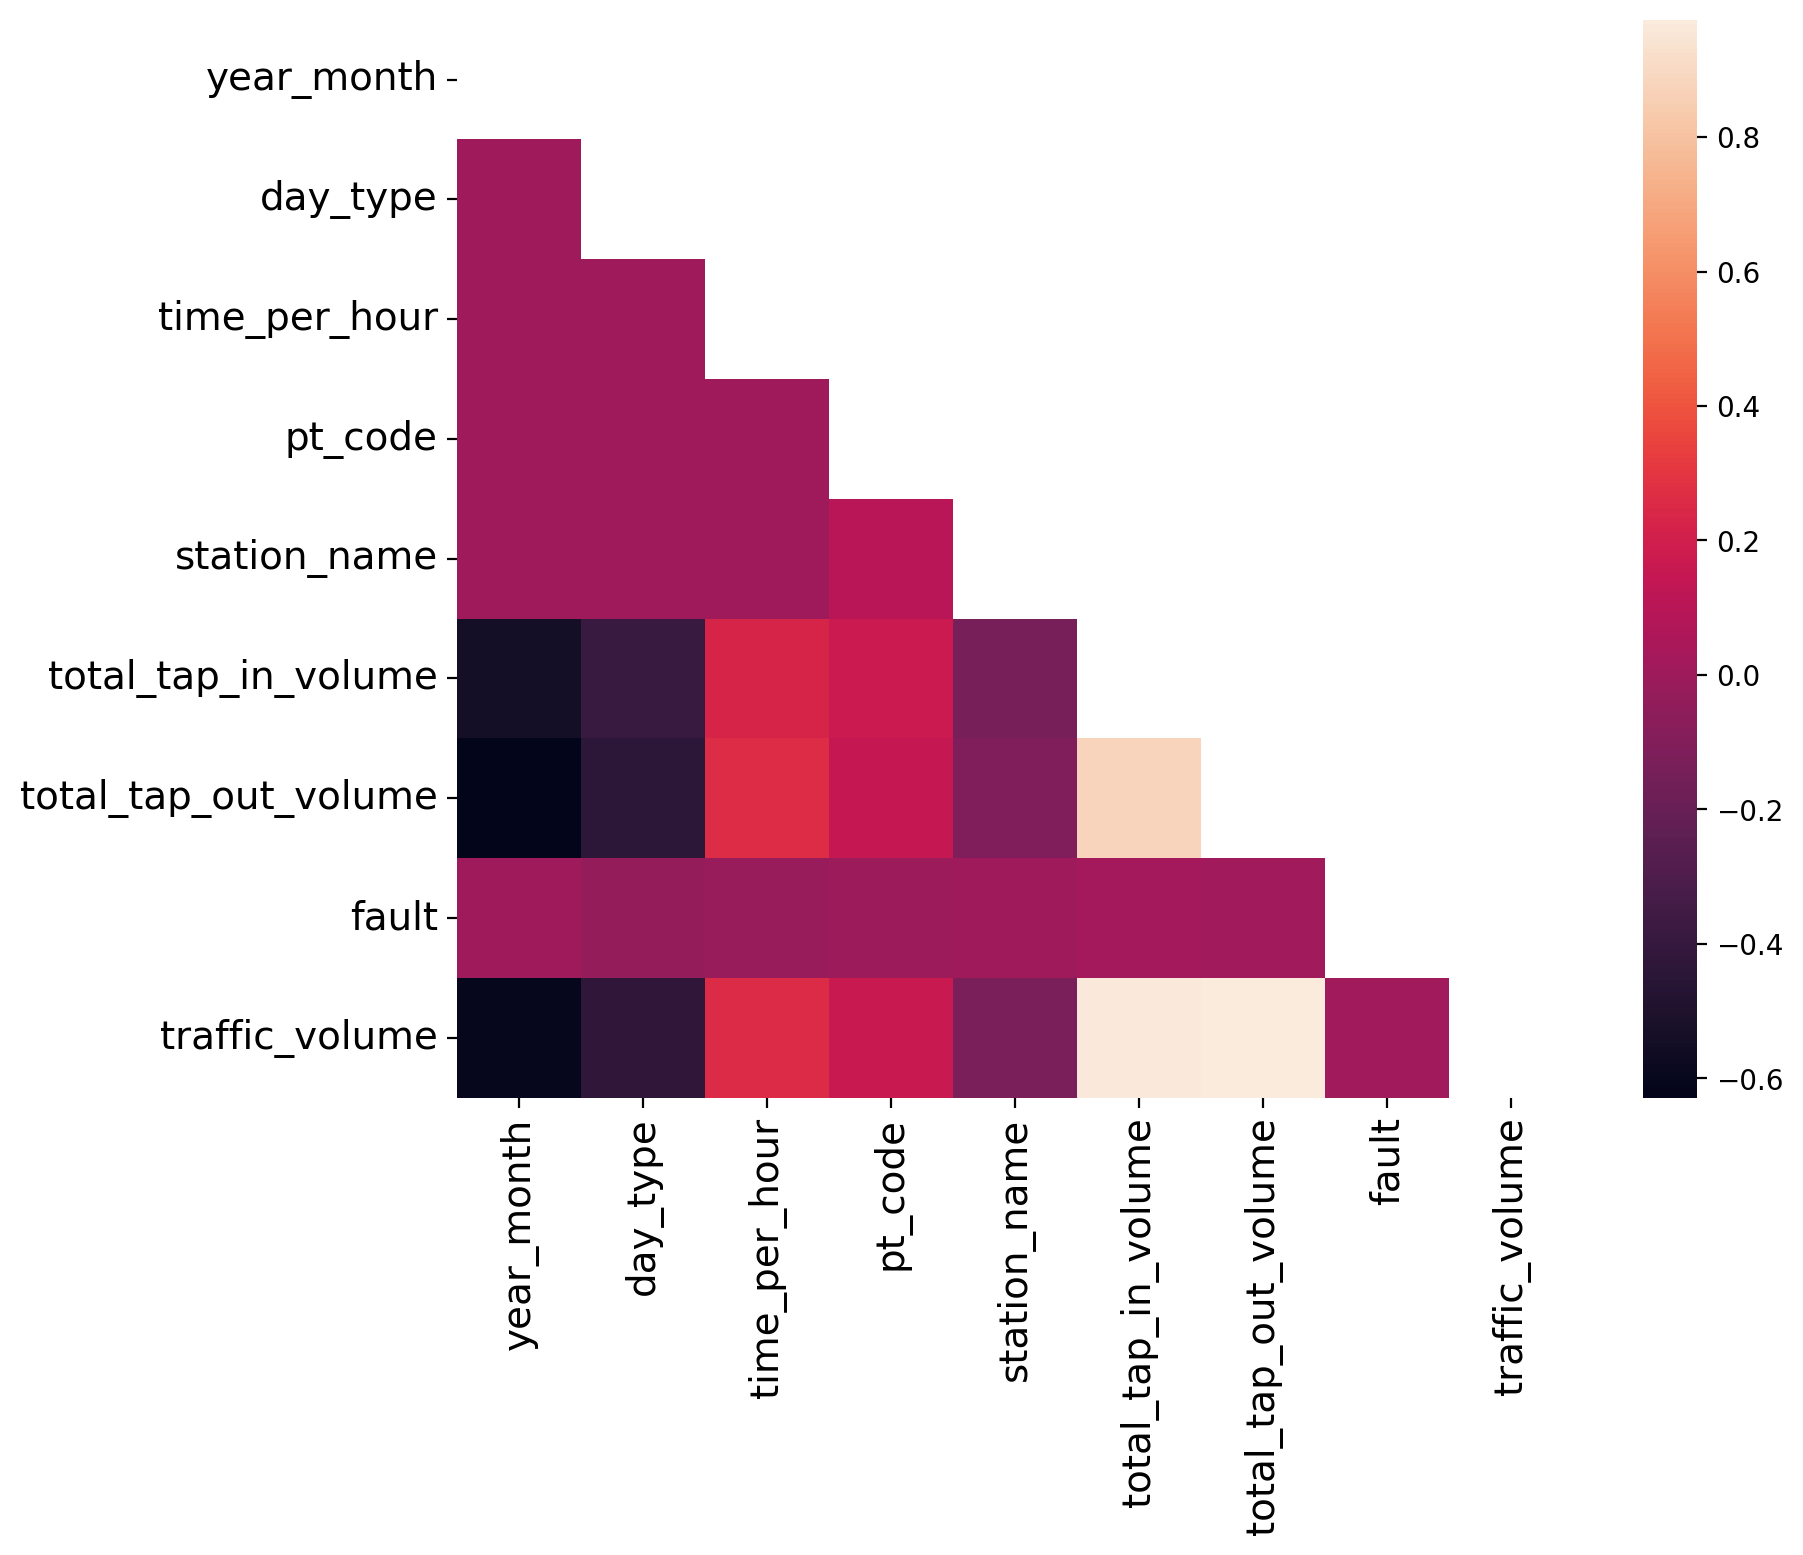

In [75]:
# Create label encoders for non-numerical columns
label_encoders = {}
for col in ['year_month', 'day_type', 'time_per_hour', 'pt_code', 'station_name']:
    label_encoders[col] = LabelEncoder()
    combinedSmrt_df[col] = label_encoders[col].fit_transform(combinedSmrt_df[col])
    
# correlation matrix
corr = combinedSmrt_df.corr()

fig, ax = plt.subplots(figsize=(9,7))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

In [76]:
# Inverse transform the encoded columns
for col in ['year_month', 'day_type', 'time_per_hour', 'pt_code', 'station_name']:
    combinedSmrt_df[col] = label_encoders[col].inverse_transform(combinedSmrt_df[col].astype(int))


From the above correlation matrix, we can see that almost all columns have near zero correlation with the target variable 'fault'

**d. Further analysis and basic plots to understand further the relationships between each feature and the target variable**

In [ ]:
# Create violin plot for time_per_hour against faults
sns.catplot(kind='violin',
           data=combinedSmrt_df,
           x='fault', y='time_per_hour')

# Show plot
plt.show()

**Insight:** From the above violin/stingray plot, we can see that stations that have faults/delay usually occurs in the morning and evening

In [ ]:
# Create violin plot for traffic_volume against faults
sns.catplot(kind='violin',
           data=combinedSmrt_df,
           x='fault', y='traffic_volume')

# Show plot
plt.show()

From the above violin/stingray plot, it doesnt say much but stations that have faults/delay have slighly higher traffic volume compared to stations with no faults/delay over the period Jan-2018 to Feb-2023

### Below, I will start to zoom into stations that have delay/faults over the 5 years

In [79]:
# Filter for breakdown stations
df_fault = combinedSmrt_df[combinedSmrt_df['fault'] == 1]
df_fault

,year_month,day_type,time_per_hour,pt_code,station_name,total_tap_in_volume,total_tap_out_volume,fault,fault_type,traffic_volume
0,2023-02,WEEKDAY,10,NS9/TE2,WOODLANDS,26154.000000,21708.000000,1,train,47862.00
1,2023-02,WEEKDAY,10,NS10,ADMIRALTY,26951.000000,11745.000000,1,train,38696.00
2,2023-02,WEEKDAY,10,NS11,SEMBAWANG,23289.000000,10574.000000,1,train,33863.00
3,2023-02,WEEKDAY,10,NS12,CANBERRA,8570.000000,4132.000000,1,train,12702.00
4,2023-02,WEEKDAY,10,NS13,YISHUN,30527.000000,19727.000000,1,train,50254.00
...,...,...,...,...,...,...,...,...,...,...
917,2018-01,WEEKDAY,7,CG2,CHANGI AIRPORT,13479.276508,16046.608847,1,signal,29525.89
918,2018-01,WEEKDAY,7,CG1/DT35,EXPO,13257.647834,15823.436101,1,signal,29081.08
919,2018-01,WEEKDAY,5,EW4/CG,TANAH MERAH,12530.874891,15030.759693,1,signal,27561.63
920,2018-01,WEEKDAY,5,CG2,CHANGI AIRPORT,13209.135578,15660.848240,1,signal,28869.98


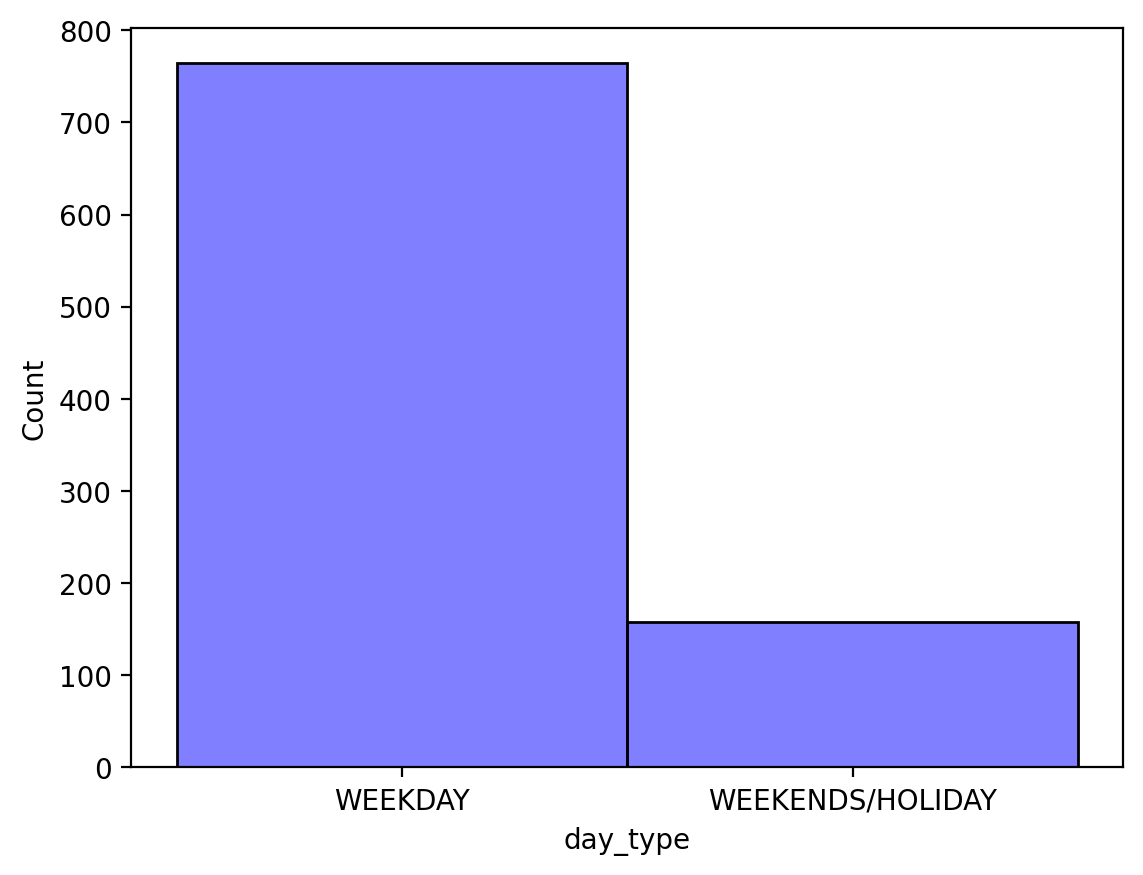

In [80]:
# Plotting Histogram for stations_breakdowns group by day_type. 
sns.histplot(data=df_fault, x="day_type", bins=30, color='blue', alpha=0.5)

plt.show()

**Insight 2:** This shows that faults happened on more in the weekdays than weeekends

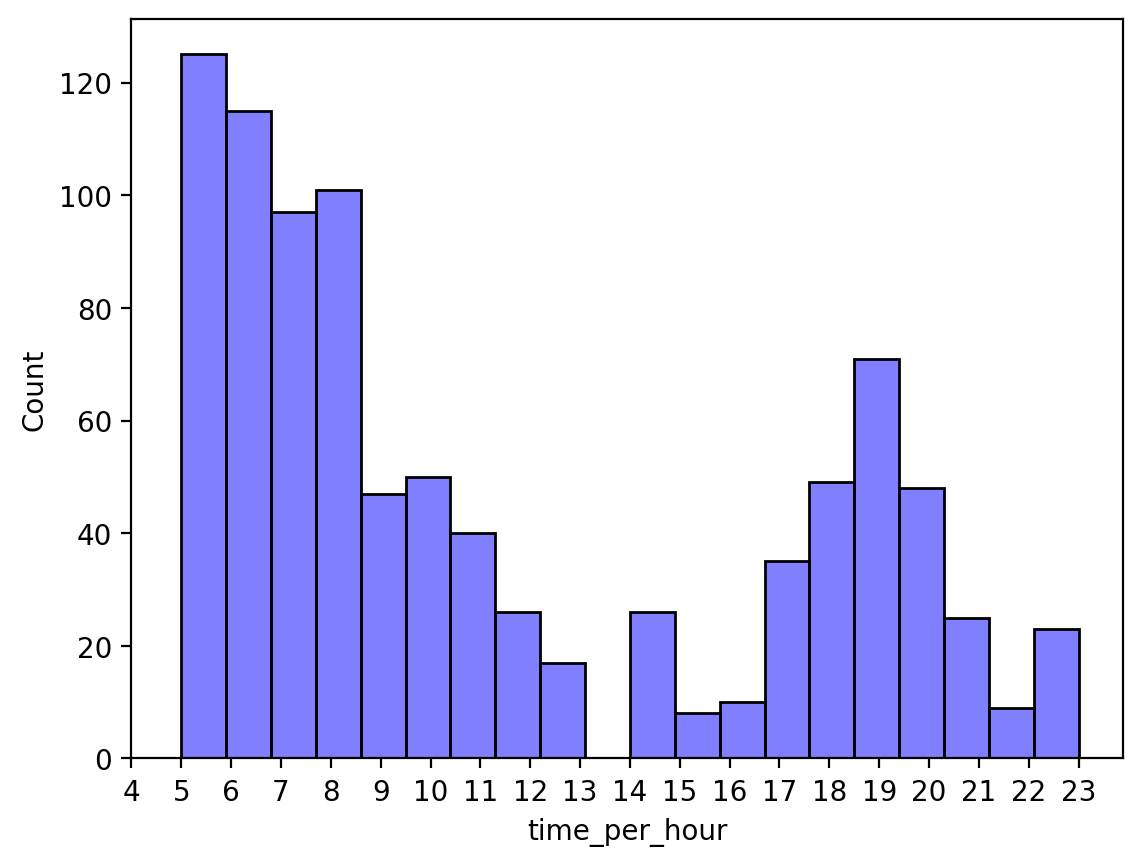

In [81]:
# Plotting Histogram for stations_breakdowns group by time_per_hour. 
sns.histplot(data=df_fault, x="time_per_hour", bins=20, color='blue', alpha=0.5)

# Set x-axis ticks to integers
plt.xticks(range(4, 24, 1))

plt.show()

**Insight 3**: Similar to Insight 1, but with more specifics, the histogram above shows that faults/delays happened more often from 5am to 10am in the morning, and also maybe 6pm to 8pm.

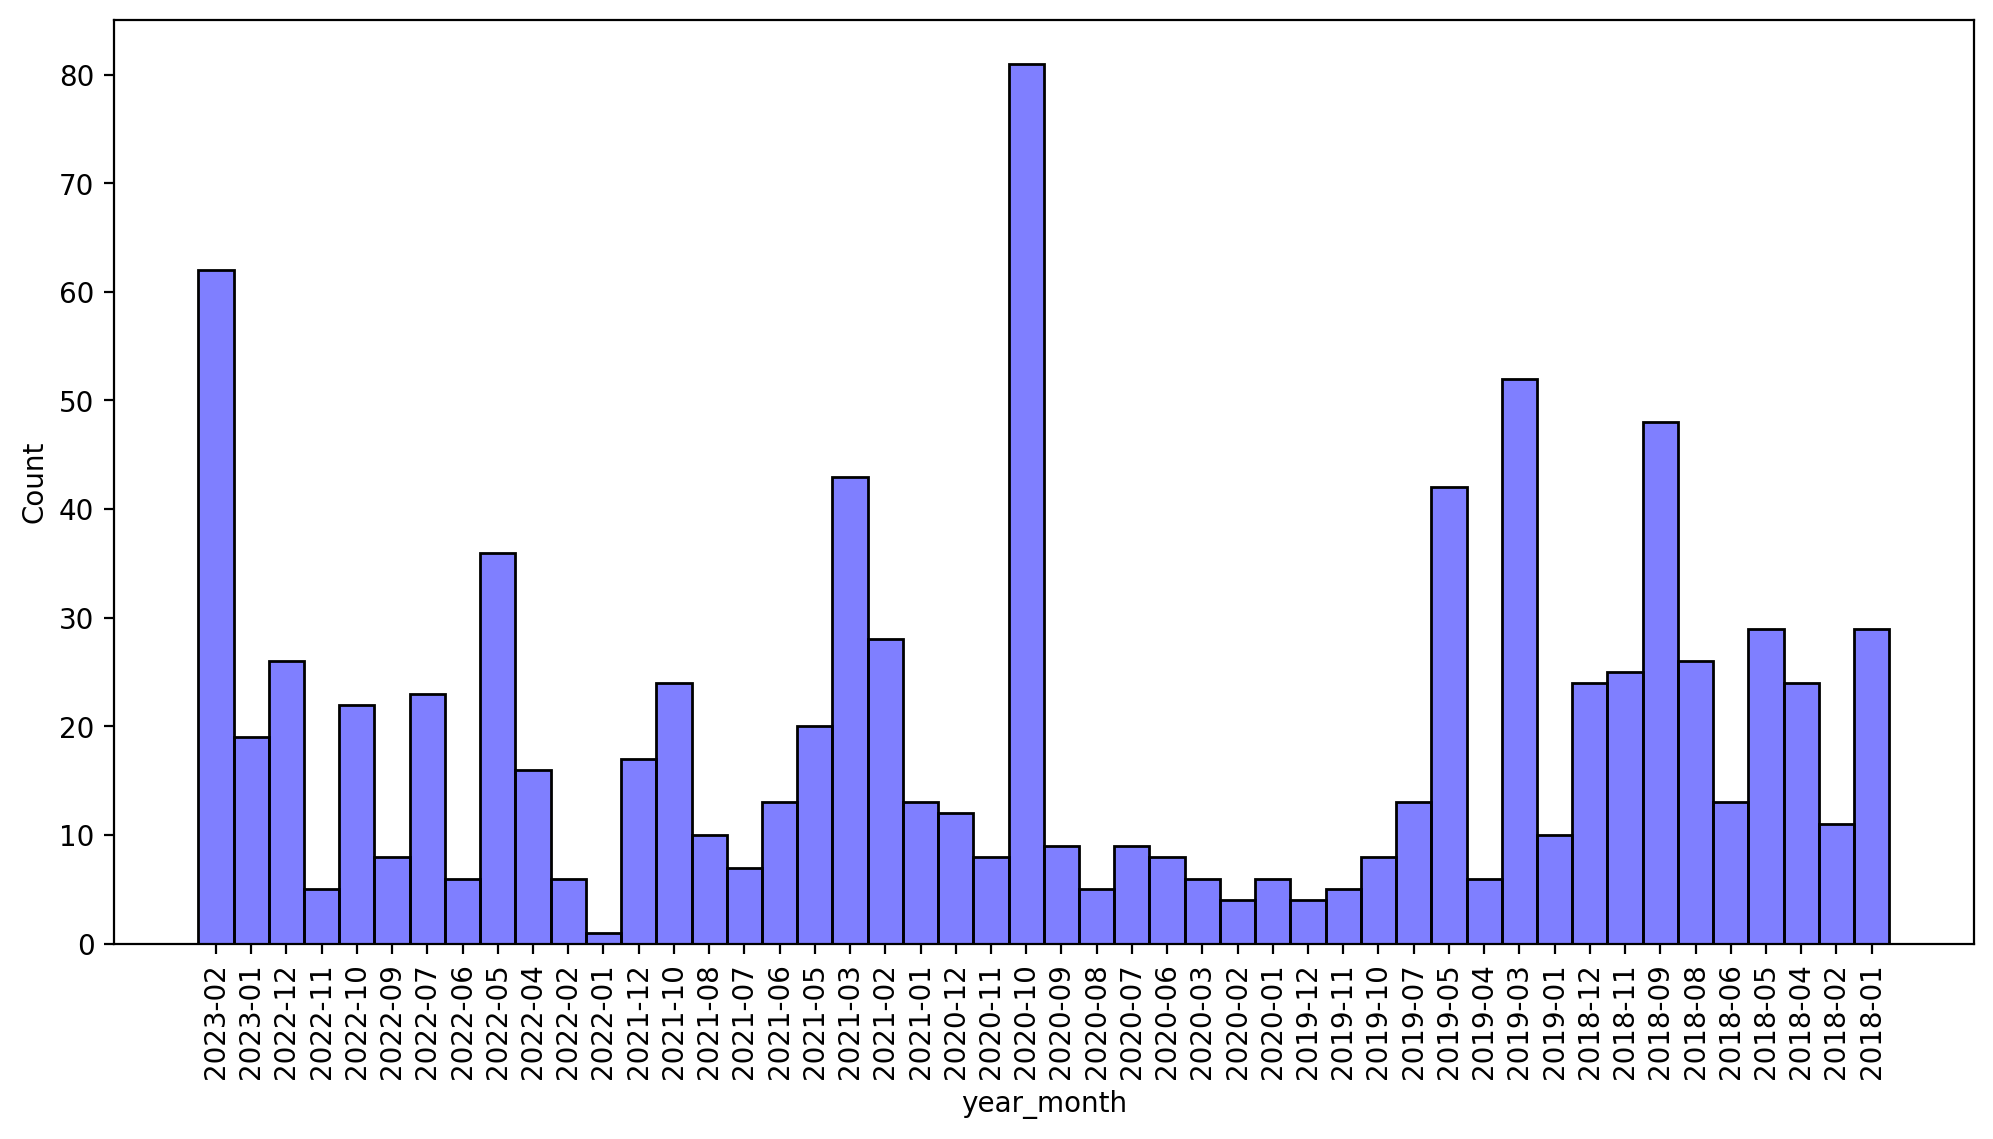

In [82]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plotting Histogram for stations_breakdowns group by year_month. 
sns.histplot(data=df_fault, x="year_month", bins=50, color='blue', alpha=0.5)

# Set x-axis ticks to integers
plt.xticks(range(0, 48, 1), rotation=90)

plt.show()

**Insight 4:** This shows that faults has been persist throughout the 5 years except for the most part of 2020 due to covid.

### Below, let's create a new column being traffic level (1 to 4) with 1 being the minimal traffic and 4 the maximum based on the traffic volume

In [83]:
# Descriptive statistics on traffic volume

combinedSmrt_df['traffic_volume'].describe()

count    424033.000000
mean      21152.757624
std        7309.119939
min           0.000000
25%       16896.840000
50%       21294.910000
75%       25568.860000
max      244956.000000
Name: traffic_volume, dtype: float64

In [84]:
# Define the range limits for each traffic level based on the descriptive stats above
level1_max = 16896
level2_max = 21294
level3_max = 25568

# Create a function to assign the crowd level based on 'total_net_taps_volume'
def assign_traffic_level(x):
    if x <= level1_max:
        return 1
    elif x <= level2_max:
        return 2
    elif x <= level3_max:
        return 3
    else:
        return 4

# Create the 'crowd_level' column using the assign_traffic_level function
combinedSmrt_df['traffic_level'] = combinedSmrt_df['traffic_volume'].apply(assign_traffic_level)


In [85]:
combinedSmrt_df.sample(5)

,year_month,day_type,time_per_hour,pt_code,station_name,total_tap_in_volume,total_tap_out_volume,fault,fault_type,traffic_volume,traffic_level
386087,2018-06,WEEKDAY,10,PW4,SAMUDERA,13584.683739,16219.756938,0,NaN,29804.44,4
47772,2022-08,WEEKENDS/HOLIDAY,15,DT20,FORT CANNING,6172.527469,5920.493005,0,NaN,12093.02,1
249544,2020-02,WEEKENDS/HOLIDAY,6,PW4,SAMUDERA,8484.815028,9056.720192,0,NaN,17541.54,2
173746,2021-01,WEEKDAY,8,NS13,YISHUN,9240.787294,10438.138573,0,NaN,19678.93,2
170304,2021-02,WEEKDAY,18,PE1,COVE,12185.575329,13944.568802,0,NaN,26130.14,4


**Export csv to upload to Tableau for more/further anaylsis and visualization**

In [ ]:
# Export to csv
combinedSmrt_df.to_csv('final_smrt.csv', index=False)

**We will continue the rest of the analysis in a separate workbook. Please refer to "3. Modelling" for the portion on modelling.**